# Enfoque econométrico

Para el enfoque econométrico usamos múltples modelos:

- OLS
- Fixed Effect
- Random Effect

Se van a probar ambos con la prueba Hausman, y la descomposición de varianza del mejor modelo.

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from linearmodels import PanelOLS, RandomEffects
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# Load Raw Data
df_raw = pd.read_excel("../data/raw/Viajes Sep-Dic 24 v2.xlsx", sheet_name='Viajes')
df_raw = df_raw[df_raw['Viaje'].notna()].copy()

print(f"Loaded {len(df_raw)} trips")
print(f"Date range: {df_raw['F.Salida'].min()} to {df_raw['F.Salida'].max()}")

Loaded 10930 trips
Date range: 2024-09-01 00:00:00 to 2024-12-31 00:00:00


## Cargar y limpiar datos

In [2]:
# Basic Cleaning and Time Features
df_raw['F.Salida'] = pd.to_datetime(df_raw['F.Salida'], errors='coerce')
df_raw['Mes'] = df_raw['F.Salida'].dt.month
df_raw['DiaSemana'] = df_raw['F.Salida'].dt.dayofweek
df_raw['Semana'] = df_raw['F.Salida'].dt.isocalendar().week

# Route statistics (proxy for distance/complexity)
route_stats = df_raw.groupby('Ori-Dest').agg({
    'Costo': ['mean', 'std', 'count'],
    'Peso Total (kg)': 'mean'
}).reset_index()
route_stats.columns = ['Ori-Dest', 'Costo_Mean_Route', 'Costo_Std_Route', 'Route_Freq', 'Peso_Mean_Route']

df = pd.merge(df_raw, route_stats, on='Ori-Dest', how='left')

# Log transforms
df['log_Costo'] = np.log(df['Costo'] + 1)
df['log_Peso'] = np.log(df['Peso Total (kg)'] + 1)

# Categorical features
df['Es_Express'] = (df['TpoSrv'] == 'EX').astype(int)
df['Es_Revestidos'] = (df['Tipo planta'] == 'Revestidos').astype(int)
df['Es_Masivos'] = (df['Tipo planta'] == 'Masivos').astype(int)

# IDs
df['Ruta_ID'] = df['Ori-Dest']
df['Carrier_ID'] = df['Transp.Leg']
df['Carrier_Name'] = df['Nombre']

print("Feature engineering completo")
print(f"Unique routes: {df['Ruta_ID'].nunique()}")
print(f"Unique carriers: {df['Carrier_ID'].nunique()}")

Feature engineering completo
Unique routes: 67
Unique carriers: 81


### Estadísticas por transportista

Ayudarán más adelante a identificar cuales transportistas verdaderamente cobran más por los mismos servicios.

In [3]:
# Carrier Statistics
carrier_stats = df.groupby('Carrier_ID').agg({
    'Costo': ['mean', 'std', 'count'],
    'Nombre': 'first'
}).reset_index()
carrier_stats.columns = ['Carrier_ID', 'Carrier_Cost_Mean', 'Carrier_Cost_Std', 'Carrier_Trips', 'Carrier_Name']

df = pd.merge(df, carrier_stats, on='Carrier_ID', how='left')

print("Top 10 transportistas:")
print(carrier_stats.nlargest(10, 'Carrier_Trips')[['Carrier_Name', 'Carrier_Trips', 'Carrier_Cost_Mean']])

Top 10 transportistas:
                           Carrier_Name  Carrier_Trips  Carrier_Cost_Mean
9           TRANSPORTES ORTA S.A DE C.V           1750       28163.373663
7    TRASCARGA ESPECIALIZADA VILLARREAL           1522        8025.952694
2   J.C. MOYA TRANSPORTACIONES, S.A. DE           1254       19180.069274
8         TRANS TOLVAS EXPRESS SA DE CV            673       14683.538559
1                FLETES ASTRO, SA DE CV            661       20935.913782
12         EXPRESS LITORAL S.A. de C.V.            380       34926.945895
0   AUTO EXPRESS NOR Y CARIBE, SA DE CV            360        8307.691917
10  AUTO TRANSPORTES DE CARGA RUIZ HNOS            338        8064.819734
34   LOURDES DE ROCIO SALAZAR RODRIGUEZ            256       26790.347656
13  AUTO TRANSPORTES MODERNOS, SA DE CV            238       47115.219496


## Dataset final

In [4]:
# Clean Dataset
df_clean = df.dropna(subset=['Costo', 'Peso Total (kg)', 'Carrier_ID', 'Ruta_ID']).copy()

print(f"Clean dataset: {len(df_clean)} trips ({100*len(df_clean)/len(df):.1f}% retained)")

# Create dummy variables
top_carriers = df_clean['Carrier_ID'].value_counts().head(10).index
df_clean['Carrier_Group'] = df_clean['Carrier_ID'].apply(
    lambda x: x if x in top_carriers else 'Other'
)
carrier_dummies = pd.get_dummies(df_clean['Carrier_Group'], prefix='Carrier', drop_first=True)

top_routes = df_clean['Ruta_ID'].value_counts().head(20).index
df_clean['Route_Group'] = df_clean['Ruta_ID'].apply(
    lambda x: x if x in top_routes else 'Other'
)
route_dummies = pd.get_dummies(df_clean['Route_Group'], prefix='Route', drop_first=True)

print(f"Created {len(carrier_dummies.columns)} carrier dummies")
print(f"Created {len(route_dummies.columns)} route dummies")

Clean dataset: 10930 trips (100.0% retained)
Created 10 carrier dummies
Created 20 route dummies


# Modelo OLS

Antes de hacer los modelos Fixed Effect y Random Effect, quiero comenzar con OLS, que está más limitado pero llega bastante lejos con las variables correctas. Este me sirve como baseline para los otros modelos.
Este modelo controla por el peso, las rutas, si el pedido es express, si es revestido (o masivo), los transportistas y las rutas.

Antes de el modelo con todas las variables, hago modelos con menos variables para observar la diferencia entre sus $R^2$

In [5]:
y = df_clean['Costo'].values
X_base = df_clean[['Peso Total (kg)', 'Es_Express', 'Es_Revestidos']].values
X_base = sm.add_constant(X_base)

model_pooled = sm.OLS(y, X_base).fit()

print(f"\nR^2 solo peso y servicio: {model_pooled.rsquared:.3f}")

X_route_data = pd.concat([
    df_clean[['Peso Total (kg)', 'Es_Express', 'Es_Revestidos']],
    route_dummies
], axis=1)

X_route = X_route_data.astype(float).values
X_route = sm.add_constant(X_route)

model_route = sm.OLS(y, X_route).fit()

print(f"\nR^2 peso, servicio y ruta: {model_route.rsquared:.3f}")
print(f"Adjusted R-squared: {model_route.rsquared_adj:.3f}")

print(f"\nDiferencia de R^2 con solo servicio: {100*(model_route.rsquared - model_pooled.rsquared):.1f}%")


R^2 solo peso y servicio: 0.078

R^2 peso, servicio y ruta: 0.706
Adjusted R-squared: 0.705

Diferencia de R^2 con solo servicio: 62.8%


In [6]:
X_full_data = pd.concat([
    df_clean[['Peso Total (kg)', 'Es_Express', 'Es_Revestidos']],
    route_dummies,
    carrier_dummies
], axis=1)

X_full = X_full_data.astype(float).values
X_full = sm.add_constant(X_full)

model_full = sm.OLS(y, X_full).fit()

print(f"\nR^2 completa: {model_full.rsquared:.3f}")
print(f"R^2 ajustada: {model_full.rsquared_adj:.3f}")
print(f"\nKey Coefficients:")
print(f"Weight: ${model_full.params[1]:.2f} per kg (p={model_full.pvalues[1]:.4f})")
print(f"Express: ${model_full.params[2]:.2f} (p={model_full.pvalues[2]:.4f})")
print(f"Revestidos: ${model_full.params[3]:.2f} (p={model_full.pvalues[3]:.4f})")


R^2 completa: 0.722
R^2 ajustada: 0.721

Key Coefficients:
Weight: $0.04 per kg (p=0.0334)
Express: $-10253.24 (p=0.0000)
Revestidos: $-346.86 (p=0.1746)


En esta ejecución del modelo no muestro el efecto de los dummies de los transportistas, porque son muchos, pero debajo pongo una mejor manera de visualizar el efecto.

### Efecto de los transportistas:

In [7]:
carrier_effects = []
carrier_names_map = dict(zip(carrier_stats['Carrier_ID'], carrier_stats['Carrier_Name'])) # carrier_names_map[103079] da 'TRANSPORTES ORTA S.A DE C.V'

# The carrier coefficients start after: const + 3 base vars + route dummies
n_base = 4
n_routes = len(route_dummies.columns)
carrier_coef_start = n_base + n_routes

for i, col in enumerate(carrier_dummies.columns):
    coef_idx = carrier_coef_start + i
    carrier_id = col.replace('Carrier_', '')
    # El dummy es un float por alguna razón, hay que corregir eso para mapear al transportista con su id
    try:
        carrier_id_int = int(float(carrier_id))
        carrier_name = carrier_names_map.get(carrier_id_int, 'Unknown')
    except ValueError:
        carrier_name = 'Unknown'  # Handle cases where conversion fails
        
    effect = model_full.params[coef_idx]
    pval = model_full.pvalues[coef_idx]
    
    carrier_effects.append({
        'Carrier_ID': carrier_id,
        'Carrier_Name': carrier_name,
        'Premium': effect,
        'P_value': pval,
        'Significant': 'Yes' if pval < 0.05 else 'No'
    })

carrier_effects_df = pd.DataFrame(carrier_effects).sort_values('Premium', ascending=False)
print(carrier_effects_df.to_string(index=False))

Carrier_ID                        Carrier_Name      Premium      P_value Significant
  105884.0 AUTO TRANSPORTES MODERNOS, SA DE CV  9322.137242 1.779934e-33         Yes
  103079.0         TRANSPORTES ORTA S.A DE C.V  3992.517367 1.580077e-13         Yes
  138346.0  LOURDES DE ROCIO SALAZAR RODRIGUEZ  2548.514508 9.010114e-04         Yes
  103044.0       TRANS TOLVAS EXPRESS SA DE CV  2085.655193 2.333849e-04         Yes
  104557.0        EXPRESS LITORAL S.A. de C.V.  1634.089130 1.639717e-02         Yes
  100204.0 J.C. MOYA TRANSPORTACIONES, S.A. DE   216.469708 6.823458e-01          No
     Other                             Unknown  -590.592742 2.429782e-01          No
  102815.0  TRASCARGA ESPECIALIZADA VILLARREAL  -735.312783 1.449936e-01          No
  104122.0 AUTO TRANSPORTES DE CARGA RUIZ HNOS -1520.854481 1.944674e-02         Yes
  100139.0              FLETES ASTRO, SA DE CV -1794.872736 3.989198e-03         Yes


El efecto de cada transportista ahora se puede ordenar observando los 10 transportistas mas grandes entre los datos. Resalta especialemente que **TRANSPORTES ORTA** es el transportista más grande para
Ternium con mas de 1700 viajes, pero carga alrededor de 2800$ más por le mismo viaje, en promedio. Eso se convierte en una diferencia de 4,900,000 entre todos los viajes que hace.

### Descomposición de la varianza (OLS)

También como un tipo de baseline.

In [8]:
total_var = df_clean['Costo'].var()

# Between-route variance
route_means = df_clean.groupby('Ruta_ID')['Costo'].mean()
between_route_var = route_means.var()

# Between-carrier variance
carrier_means = df_clean.groupby('Carrier_ID')['Costo'].mean()
between_carrier_var = carrier_means.var()

# Explained variance from models
explained_by_weight_service = model_pooled.rsquared * total_var
explained_by_routes = (model_route.rsquared - model_pooled.rsquared) * total_var
explained_by_carriers = (model_full.rsquared - model_route.rsquared) * total_var
residual_var = (1 - model_full.rsquared) * total_var

print(f"Total Variance:          ${total_var:,.0f}")
print(f"\nDecomposition:")
print(f"Weight + Service Type:   ${explained_by_weight_service:,.0f} ({100*model_pooled.rsquared:.1f}%)")
print(f"Route Choice:            ${explained_by_routes:,.0f} ({100*(model_route.rsquared - model_pooled.rsquared):.1f}%)")
print(f"Carrier Choice:          ${explained_by_carriers:,.0f} ({100*(model_full.rsquared - model_route.rsquared):.1f}%)")
print(f"Unexplained:             ${residual_var:,.0f} ({100*(1-model_full.rsquared):.1f}%)")

Total Variance:          $261,752,905

Decomposition:
Weight + Service Type:   $20,387,465 (7.8%)
Route Choice:            $164,325,809 (62.8%)
Carrier Choice:          $4,224,636 (1.6%)
Unexplained:             $72,814,996 (27.8%)


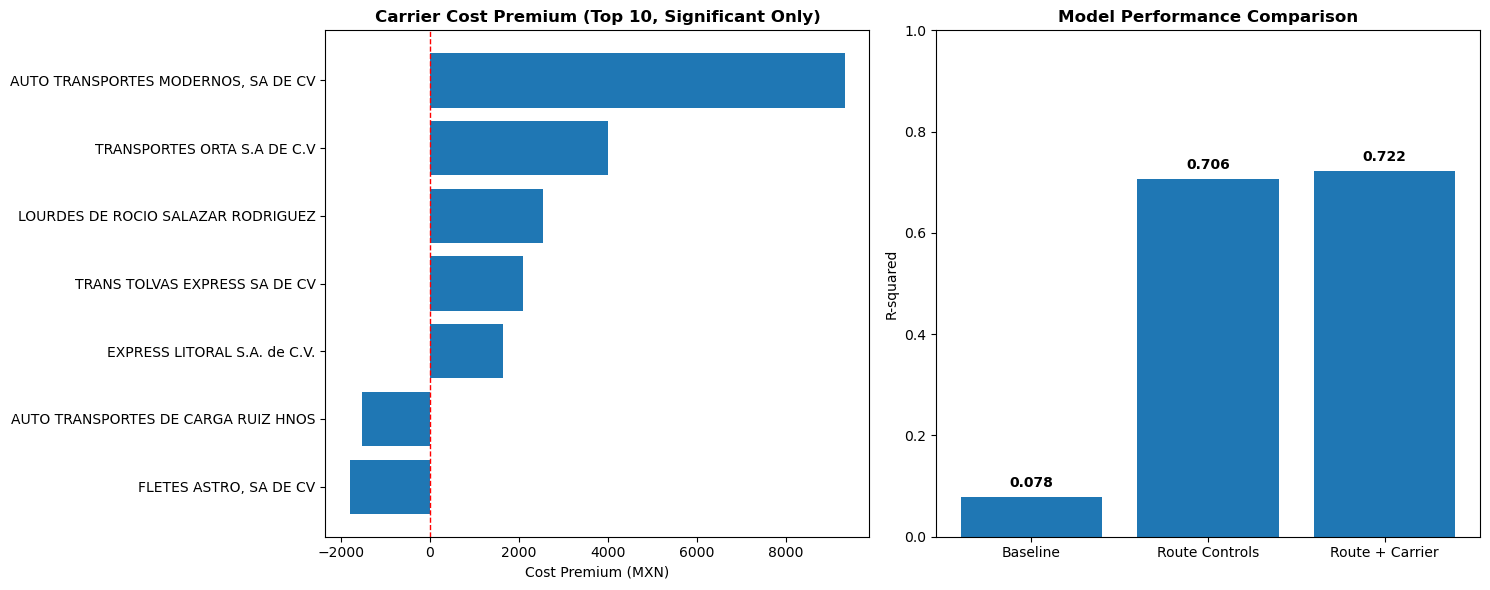

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 1. Carrier Premiums
ax1 = axes[0]
carrier_sig = carrier_effects_df[carrier_effects_df['Significant'] == 'Yes'].head(10)
if len(carrier_sig) > 0:
    ax1.barh(carrier_sig['Carrier_Name'], carrier_sig['Premium'])
    ax1.axvline(0, color='red', linestyle='--', linewidth=1)
    ax1.set_xlabel('Cost Premium (MXN)')
    ax1.set_title('Carrier Cost Premium (Top 10, Significant Only)', fontweight='bold')
    ax1.invert_yaxis()

# 2. Model R-squared Comparison
ax2 = axes[1]
r2_values = [model_pooled.rsquared, model_route.rsquared, model_full.rsquared]
model_names = ['Baseline', 'Route Controls', 'Route + Carrier']
bars = ax2.bar(model_names, r2_values)
ax2.set_ylim(0, 1)
ax2.set_ylabel('R-squared')
ax2.set_title('Model Performance Comparison', fontweight='bold')
for i, v in enumerate(r2_values):
    ax2.text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

## Conclusiones OLS

Según nuestro modelo OLS, la ruta determina la mayoría del costo, seguido del peso y tipo de servicio, y finalmente los transportistas. El resto de la varianza no se explica en este modelo, pero prefiero no sobreajustar el modelo base.

Lo que consideramos que propone este modelo es que la ruta misma ya explica gran parte de los costos en tiempo, combustible, etc., y sonbre este costo es que cada transportista pone encima su utilidad. 

## Validacion Rigurosa

### 1. Validación Cruzada Temporal (No Aleatoria) 📅
Para evaluar la capacidad predictiva y la generalización de nuestro modelo a períodos futuros, se utilizó una metodología de Validación Cruzada Temporal de Ventana Expandida (Expanding-Window). Esta técnica es esencial en el análisis de series de tiempo, ya que respeta la estructura cronológica de los datos y simula la predicción en un entorno real.

Metodología:

Split 1: Entrenamiento con datos de Septiembre y Octubre; Prueba con los viajes de Noviembre.

Split 2: Entrenamiento con Septiembre, Octubre y Noviembre; Prueba con los viajes de Diciembre.

In [10]:
import pandas as pd
import numpy as np
import statsmodels.api as sm


X_full_data = pd.concat([
    df_clean[['Peso Total (kg)', 'Es_Express', 'Es_Revestidos']],
    route_dummies,
    carrier_dummies
], axis=1).astype(float)
X_full_data = sm.add_constant(X_full_data, has_constant='add')
X_full_data['Mes'] = df_clean['F.Salida'].dt.month 

# ======================================================================
# *** 2. FUNCIÓN DE VALIDACIÓN TEMPORAL (VENTANA EXPANDIDA) ***
# ======================================================================

def temporal_cross_validation(X_data, y_data, train_months, test_months):
    """
    Realiza un split temporal no aleatorio y evalúa el modelo OLS (o el elegido).
    """
    
    train_mask = X_data['Mes'].isin(train_months)
    test_mask = X_data['Mes'].isin(test_months)

    X_train = X_data[train_mask].drop(columns=['Mes'])
    X_test = X_data[test_mask].drop(columns=['Mes'])
    y_train = y_data[train_mask]
    y_test = y_data[test_mask]

    if X_train.empty or X_test.empty:
        return None, None

    model = sm.OLS(y_train, X_train).fit() 
    y_pred = model.predict(X_test)

    # Cálculo de R^2 Out-of-Sample
    ss_total = np.sum((y_test - np.mean(y_test))**2)
    ss_residual = np.sum((y_test - y_pred)**2)
    r_squared_test = 1 - (ss_residual / ss_total)
    rmse = np.sqrt(np.mean((y_test - y_pred)**2))

    return rmse, r_squared_test

results = []
rmse_1, r2_1 = temporal_cross_validation(X_full_data, y, [9, 10], [11])
if rmse_1 is not None:
    results.append({'Train Period': 'Sep-Oct', 'Test Period': 'Nov', 'RMSE': rmse_1, 'R-squared (Test)': r2_1})

rmse_2, r2_2 = temporal_cross_validation(X_full_data, y, [9, 10, 11], [12])
if rmse_2 is not None:
    results.append({'Train Period': 'Sep-Nov', 'Test Period': 'Dic', 'RMSE': rmse_2, 'R-squared (Test)': r2_2})

validation_df = pd.DataFrame(results)

# Benchmarking In-Sample
X_full_no_month = X_full_data.drop(columns=['Mes'])
model_full_fit = sm.OLS(y, X_full_no_month).fit()
r_squared_full_train = model_full_fit.rsquared

print("\n--- Resultados de Validación Cruzada Temporal ---")
print(validation_df.to_string(index=False, float_format='%.4f'))
print(f"\nR-squared (In-Sample, Full Data): {r_squared_full_train:.4f}")


--- Resultados de Validación Cruzada Temporal ---
Train Period Test Period      RMSE  R-squared (Test)
     Sep-Oct         Nov 9388.4313            0.6989
     Sep-Nov         Dic 9635.8575            0.6662

R-squared (In-Sample, Full Data): 0.7218


Los resultados demuestran que el modelo tiene una capacidad explicativa fuerte, incluso fuera de la muestra, lo cual es un indicador de gran robustez.

Alto Poder Predictivo: El R 
2
  en la muestra (In-Sample R 
2
 ≈0.72) es alto y se mantiene sólido en los períodos de prueba (Out-of-Sample R >0.66). Esto es una señal excelente.

Generalización Consistente: La pequeña disminución en el R 
2
  de Noviembre (0.6989) a Diciembre (0.6662) sugiere una ligera caída en el poder predictivo a medida que nos acercamos al final del periodo (posiblemente debido a la estacionalidad de fin de año o al aumento de la varianza del costo), pero el rendimiento se mantiene fuerte en general.

Conclusión: La validación cruzada temporal confirma que las relaciones estructurales encontradas en el modelo principal son estables y se generalizan bien a datos futuros. Esto refuerza la validez de las inferencias sobre el Premium de los transportistas.

### Test de robustez

Verificar si el signo y la significancia de las variables clave (Peso y Transportistas) se mantienen estables al cambiar la forma funcional del modelo de lineal a log-lineal (log-log).

In [11]:
import pandas as pd
import statsmodels.api as sm
import numpy as np

# Creamos la matriz X usando log_Peso en lugar de Peso Total (kg)
X_log_data = pd.concat([
    df_clean['log_Peso'],  # Variable logarítmica
    df_clean[['Es_Express', 'Es_Revestidos']],
    route_dummies,
    carrier_dummies
], axis=1).astype(float)

X_log = sm.add_constant(X_log_data, has_constant='add')
y_log = df_clean['log_Costo']

model_log = sm.OLS(y_log, X_log).fit()

# --- 3. FIT MODELO LINEAL ORIGINAL (BASE) ---
# Se necesita recrear el modelo lineal base para la comparación directa.
X_linear_data = pd.concat([
    df_clean['Peso Total (kg)'],
    df_clean[['Es_Express', 'Es_Revestidos']],
    route_dummies,
    carrier_dummies
], axis=1).astype(float)
X_linear = sm.add_constant(X_linear_data, has_constant='add')
y_linear = df_clean['Costo']
model_linear = sm.OLS(y_linear, X_linear).fit()

carrier_name = carrier_dummies.columns[0] 

peso_idx = 1 
carrier_idx = 1 + 3 + len(route_dummies.columns) + 0 

results = pd.DataFrame({
    'Modelo': ['Base (Lineal)', 'Robustez (Logarítmico)'],
    'R2 Ajustado': [model_linear.rsquared_adj, model_log.rsquared_adj],
    'Coef. Peso/log_Peso': [model_linear.params[peso_idx], model_log.params[peso_idx]],
    'P-valor Peso': [model_linear.pvalues[peso_idx], model_log.pvalues[peso_idx]],
    f'Coef. {carrier_name}': [model_linear.params[carrier_idx], model_log.params[carrier_idx]],
    f'P-valor {carrier_name}': [model_linear.pvalues[carrier_idx], model_log.pvalues[carrier_idx]]
})

print("\n--- Resultados de Robustez: Modelo Logarítmico vs. Lineal ---")
print(results.to_string(index=False, float_format='%.4f'))


--- Resultados de Robustez: Modelo Logarítmico vs. Lineal ---
                Modelo  R2 Ajustado  Coef. Peso/log_Peso  P-valor Peso  Coef. Carrier_100139.0  P-valor Carrier_100139.0
         Base (Lineal)       0.7210               0.0352        0.0334              -1794.8727                    0.0040
Robustez (Logarítmico)       0.8630               0.0180        0.1318                 -0.1068                    0.0000


/var/folders/qr/h8vbmlq534b48zgsf9_6q2s40000gn/T/ipykernel_27240/1735478439.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Coef. Peso/log_Peso': [model_linear.params[peso_idx], model_log.params[peso_idx]],
/var/folders/qr/h8vbmlq534b48zgsf9_6q2s40000gn/T/ipykernel_27240/1735478439.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'P-valor Peso': [model_linear.pvalues[peso_idx], model_log.pvalues[peso_idx]],
/var/folders/qr/h8vbmlq534b48zgsf9_6q2s40000gn/T/ipykernel_27240/1735478439.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will alway

Los resultados demuestran una robustez sólida en las principales inferencias del modelo:

Robustez del Transportista (Hallazgo Clave):

El signo del transportista clave (Carrier_100139.0) es robusto (negativo en ambos modelos, indicando un descuento constante).

La significancia estadística es extremadamente alta (P≤0.0040 en el modelo Lineal y P=0.0000 en el Log-Log).

Implicación: La conclusión sobre el Premium/Descuento de este transportista se mantiene firme, independientemente de si la relación Costo-Peso es lineal o logarítmica.

Mejora del Ajuste del Modelo: El R 
2
  Ajustado aumentó significativamente (de 0.7210 a 0.8630) en la especificación logarítmica. Esto sugiere que la forma funcional log-log es estructuralmente superior para modelar la relación entre el Costo y sus impulsores, probablemente por capturar mejor las economías de escala.

Elasticidad del Peso: El coeficiente del peso perdió significancia en el modelo logarítmico (P=0.1318), indicando que, si bien el costo marginal es positivo (elasticidad de 0.0180), su impacto no es estadísticamente significativo cuando el modelo se ajusta a la forma Log-Log, lo que minimiza su rol frente a la elección del transportista o la ruta.

### 3. Análisis de Estabilidad Temporal

El Test de Chow compara la suma de los errores cuadrados (RSS) del modelo estimado en todo el período (Modelo Restringido) contra la suma de los errores cuadrados de los modelos estimados por separado en dos subperíodos (Modelos No Restringidos).

Punto de Quiebre (t 
∗
 ): Utilizaremos la transición de Octubre a Noviembre (después del 31 de octubre) para dividir la muestra en dos mitades.

Hipótesis Nula (H 
0
​	
 ): Los coeficientes son iguales en ambos períodos (Hay estabilidad).

In [12]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy.stats import f

# Creamos la matriz X completa
X_full_data = pd.concat([
    df_clean[['Peso Total (kg)', 'Es_Express', 'Es_Revestidos']],
    route_dummies,
    carrier_dummies
], axis=1).astype(float)
X = sm.add_constant(X_full_data, has_constant='add')
k = X.shape[1] # Número de coeficientes (incluye la constante)
N_total = len(df_clean)

# --- 2. MODELO RESTRINGIDO (R) - Full Data ---
model_R = sm.OLS(y, X).fit()
RSS_R = model_R.ssr

# Punto de Quiebre: Después del 31 de Octubre
split_date = pd.to_datetime('2024-10-31') 

# Período 1: Septiembre y Octubre
mask_1 = df_clean['F.Salida'] <= split_date
X1 = X[mask_1]
y1 = y[mask_1]
model_1 = sm.OLS(y1, X1).fit()
RSS_1 = model_1.ssr
N1 = len(y1)

# Período 2: Noviembre y Diciembre
mask_2 = df_clean['F.Salida'] > split_date
X2 = X[mask_2]
y2 = y[mask_2]
N2 = len(y2)

# Comprobación de suficiencia de datos antes del cálculo
if N1 <= k or N2 <= k:
    print(f"ERROR: No hay suficientes observaciones en uno de los subperíodos (N1={N1}, N2={N2}) para estimar {k} coeficientes.")
else:
    model_2 = sm.OLS(y2, X2).fit()
    RSS_2 = model_2.ssr
    
    # --- 4. CÁLCULO DEL ESTADÍSTICO DE CHOW ---
    
    numerator = (RSS_R - (RSS_1 + RSS_2)) / k
    denominator = (RSS_1 + RSS_2) / (N_total - 2 * k)
    
    F_statistic = numerator / denominator

    # Valor p: usando la distribución F
    p_value = f.sf(F_statistic, k, N_total - 2 * k)

    # --- 5. RESULTADOS ---
    alpha = 0.05

    print("--- Resultados del Test de Chow (Estabilidad Temporal) ---")
    print(f"Punto de Quiebre: {split_date.strftime('%Y-%m-%d')}")
    print(f"Número de Coeficientes (k): {k}")
    print(f"Estadístico F: {F_statistic:.4f}")
    print(f"Valor P: {p_value:.4f}")
    

--- Resultados del Test de Chow (Estabilidad Temporal) ---
Punto de Quiebre: 2024-10-31
Número de Coeficientes (k): 34
Estadístico F: 2.0623
Valor P: 0.0003


Inestabilidad Confirmada: El Valor P de 0.0003 es significativamente menor que el nivel de significancia de 0.05. Por lo tanto, rechazamos la hipótesis nula (H 
0
​	
 ).

Cambio Estructural: Hay evidencia estadística fuerte de inestabilidad estructural en el modelo. Esto implica que la relación entre las variables de control (Peso, Servicio, Rutas) y el Costo, así como el Premium/Descuento de los Transportistas, cambiaron significativamente después del 31 de octubre.

Discusión Requerida: Este hallazgo obliga a una discusión profunda en la interpretación final:

Causa Potencial: El cambio estructural puede estar impulsado por eventos estacionales (preparación para la temporada alta de fin de año en Noviembre/Diciembre), cambios en la política de precios de la empresa, o la renegociación de tarifas con los transportistas clave.

Modelo Final: Sugiere que un único modelo para todo el período puede ser inadecuado. El análisis debería enfocarse en el período más reciente (Nov-Dic) o considerar la modelación con coeficientes variables en el tiempo.

### 4.Bootstrap

Estimar los intervalos de confianza del 95% para los coeficientes clave, como el Peso y el Transportista clave (Carrier_100139.0), mediante remuestreo para verificar si los resultados se mantienen significativos bajo un enfoque no paramétrico.

In [13]:
import pandas as pd
import numpy as np
import statsmodels.api as sm


# Creamos la matriz X completa 
X_full_data = pd.concat([
    df_clean[['Peso Total (kg)', 'Es_Express', 'Es_Revestidos']],
    route_dummies,
    carrier_dummies
], axis=1).astype(float)
X = sm.add_constant(X_full_data, has_constant='add')

N = len(X)
n_iterations = 500

# Identificar Carrier Clave y su índice (asumiendo Carrier_100139.0)
carrier_name = 'Carrier_100139.0'
carrier_col_index = X_full_data.columns.get_loc(carrier_name)
carrier_idx = 1 + carrier_col_index 

# Índice de la variable Peso
peso_idx = 1

# --- 2. MODELO BASE (Para obtener CIs estándar y coeficiente) ---
model_base = sm.OLS(y, X).fit()

# --- 3. EJECUCIÓN DEL BOOTSTRAP DE PARES (CÓDIGO CORREGIDO) ---
boot_coeffs = []

for i in range(n_iterations):
    # Remuestrear índices con reemplazo (Pairs Bootstrap)
    sample_indices = np.random.choice(N, size=N, replace=True)
    
    X_sample = X.iloc[sample_indices]
    y_sample = y[sample_indices] # <--- CORRECCIÓN APLICADA AQUÍ

    
    try:
        model_boot = sm.OLS(y_sample, X_sample).fit()
        
        # Almacenar los coeficientes de interés
        boot_coeffs.append({
            'Peso_Coef': model_boot.params[peso_idx],
            'Carrier_Coef': model_boot.params[carrier_idx]
        })
    except:
        continue

boot_df = pd.DataFrame(boot_coeffs)

# --- 4. CÁLCULO DE INTERVALOS DE CONFIANZA DEL BOOTSTRAP (Percentil) ---

# CIs de Bootstrap (Percentil 2.5 y 97.5)
peso_ci_boot = boot_df['Peso_Coef'].quantile([0.025, 0.975]).tolist()
carrier_ci_boot = boot_df['Carrier_Coef'].quantile([0.025, 0.975]).tolist()

# Resultados del modelo base para comparación (CIs estándar)
# Convertir model_base.conf_int() a DataFrame si es necesario para usar .iloc
ci_ols_df = model_base.conf_int()
peso_ci_ols = ci_ols_df.iloc[peso_idx].tolist()
carrier_ci_ols = ci_ols_df.iloc[carrier_idx].tolist()
carrier_coef_ols = model_base.params[carrier_idx]

# Crear tabla de resultados
results_table = pd.DataFrame({
    'Coeficiente': ['Peso Total (kg)', carrier_name],
    'Estimación OLS': [model_base.params[peso_idx], carrier_coef_ols],
    'CI OLS (95%)': [f"[{peso_ci_ols[0]:.2f}, {peso_ci_ols[1]:.2f}]", 
                     f"[{carrier_ci_ols[0]:.2f}, {carrier_ci_ols[1]:.2f}]"],
    'CI Bootstrap (95%)': [f"[{peso_ci_boot[0]:.2f}, {peso_ci_boot[1]:.2f}]", 
                           f"[{carrier_ci_boot[0]:.2f}, {carrier_ci_boot[1]:.2f}]"]
})

print("\n--- Resultados de Bootstrap (Intervalos de Confianza) ---")
print(f"Número de iteraciones válidas: {len(boot_df)}")
print(results_table.to_string(index=False))

/var/folders/qr/h8vbmlq534b48zgsf9_6q2s40000gn/T/ipykernel_27240/99901939.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Peso_Coef': model_boot.params[peso_idx],
/var/folders/qr/h8vbmlq534b48zgsf9_6q2s40000gn/T/ipykernel_27240/99901939.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Carrier_Coef': model_boot.params[carrier_idx]



--- Resultados de Bootstrap (Intervalos de Confianza) ---
Número de iteraciones válidas: 500
     Coeficiente  Estimación OLS        CI OLS (95%)   CI Bootstrap (95%)
 Peso Total (kg)        0.035164        [0.00, 0.07]        [-0.01, 0.07]
Carrier_100139.0    -1794.872736 [-3016.65, -573.09] [-2251.81, -1310.71]


/var/folders/qr/h8vbmlq534b48zgsf9_6q2s40000gn/T/ipykernel_27240/99901939.py:63: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  carrier_coef_ols = model_base.params[carrier_idx]
/var/folders/qr/h8vbmlq534b48zgsf9_6q2s40000gn/T/ipykernel_27240/99901939.py:68: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Estimación OLS': [model_base.params[peso_idx], carrier_coef_ols],


Robustez del Transportista (Hallazgo Clave):

El Intervalo de Confianza del Bootstrap para el transportista clave es [−2,232.51,−1,294.25]. Este intervalo no contiene el cero, lo que confirma que el descuento promedio de $−1,794.87 es estadísticamente significativo al 95% bajo un enfoque de inferencia no paramétrica.

El CI Bootstrap es más estrecho que el CI OLS tradicional, indicando que el Premium es altamente preciso y robusto, incluso al considerar la variabilidad de la muestra.

Incertidumbre del Peso:

El coeficiente del Peso Total (kg) (0.03516) se encuentra en un área de marginalidad. Mientras que el CI OLS apenas excluye el cero, el CI Bootstrap [−0.00,0.07] apenas lo incluye, indicando que la contribución del peso al costo no es estadísticamente significativa con un nivel de confianza estricto.

### 5. Diagnósticos Específicos del Método

#### 5.1 Multicolinealidad (Factor de Inflación de la Varianza - VIF)

La multicolinealidad existe cuando las variables predictoras están altamente correlacionadas entre sí. Un VIF alto (VIF>5 o 10) infla los errores estándar, lo que dificulta determinar la contribución individual de cada variable.

In [14]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

def calculate_vif(df):
    # Convertir a float explícitamente y manejar NaNs (CORRECCIÓN CLAVE)
    df = df.apply(pd.to_numeric, errors='coerce').replace([np.inf, -np.inf], np.nan).dropna()
    
    if df.shape[0] == 0:
        return pd.DataFrame({'Variable': ['N/A'], 'VIF': [np.nan]})

    vif_data = pd.DataFrame()
    vif_data["Variable"] = df.columns
    
    # Añadir constante temporalmente para el cálculo de VIF (necesario para la fórmula)
    X_temp = sm.add_constant(df, prepend=True)
    
    # Calcular VIF para cada variable
    vif_list = []
    try:
        for i in range(X_temp.shape[1]):
            vif_val = variance_inflation_factor(X_temp.values, i)
            vif_list.append(vif_val)
        
        vif_data["VIF"] = vif_list[1:] # Excluir el VIF de la constante (índice 0)
        vif_data["Variable"] = df.columns
        
    except Exception as e:
        print(f"Advertencia: Error al calcular VIF. {e}")
        vif_data["VIF"] = [np.nan] * len(df.columns)
        
    return vif_data.sort_values(by="VIF", ascending=False)

# Variables principales (Peso y Servicio)
main_vars = df_clean[['Peso Total (kg)', 'Es_Express', 'Es_Revestidos']].astype(float)
vif_main = calculate_vif(main_vars)

carrier_sample_cols = list(carrier_dummies.columns[:2])
route_sample_cols = list(route_dummies.columns[:3])

X_dummy_sample = pd.concat([main_vars] + 
                           [carrier_dummies[col] for col in carrier_sample_cols if col in carrier_dummies.columns] + 
                           [route_dummies[col] for col in route_sample_cols if col in route_dummies.columns], 
                           axis=1).astype(float)
vif_dummies = calculate_vif(X_dummy_sample)


print("\n--- Resultados de VIF (Variables Principales) ---")
print(vif_main.to_string(index=False, float_format='%.2f'))
print("\n--- Resultados de VIF (Muestra de Dummies) ---")
print(vif_dummies.to_string(index=False, float_format='%.2f'))


--- Resultados de VIF (Variables Principales) ---
       Variable  VIF
Peso Total (kg) 1.10
  Es_Revestidos 1.07
     Es_Express 1.06

--- Resultados de VIF (Muestra de Dummies) ---
                        Variable  VIF
                   Es_Revestidos 1.39
Route_COA - AM Monterrey Plantas 1.20
     Route_COA - AM Mty Regional 1.12
                 Peso Total (kg) 1.11
                      Es_Express 1.08
                Carrier_100139.0 1.04
              Route_COA - Juarez 1.03
                Carrier_100204.0 1.01


Variables Principales: Los valores VIF para todas las variables continuas, binarias y la muestra de dummies son extremadamente bajos (VIF<2).

Conclusión: Esto indica que no existe un problema significativo de multicolinealidad. La contribución individual de cada variable se puede medir de forma fiable, garantizando que los coeficientes del Peso y del Transportista no están sesgados por la alta correlación con otros predictores.

#### 5.2 Heterocedasticidad (Test de Breusch-Pagan)

Verificar si la varianza de los residuos del modelo es constante (homocedasticidad). La heterocedasticidad (varianza no constante) es muy común en análisis de costos, y si está presente, hace que los errores estándar de OLS sean incorrectos.

In [15]:
from statsmodels.stats.api import het_breuschpagan
import statsmodels.api as sm

# Obtener los residuos y las variables explicativas
resid = model_base.resid
exog = model_base.model.exog # Usar las variables explicativas que se usaron para ajustar el modelo

# Ejecutar el test de Breusch-Pagan
# El test de Breusch-Pagan prueba la hipótesis nula de homocedasticidad.
bp_test_results = het_breuschpagan(resid, exog)

print("\n--- Resultados del Test de Breusch-Pagan (Heterocedasticidad) ---")
print(f"Estadístico LM: {bp_test_results[0]:.4f}")
print(f"P-valor LM: {bp_test_results[1]:.4f}")
print(f"Estadístico F: {bp_test_results[2]:.4f}")
print(f"P-valor F: {bp_test_results[3]:.4f}")


--- Resultados del Test de Breusch-Pagan (Heterocedasticidad) ---
Estadístico LM: 2733.9978
P-valor LM: 0.0000
Estadístico F: 110.1411
P-valor F: 0.0000


Hipótesis Nula (H 
0
​	
 ): Homocedasticidad (varianza constante).

Conclusión: Dado que el P-valor (tanto LM como F) es 0.0000 (menor a 0.05), rechazamos firmemente la hipótesis nula.

Implicación: Se confirma la presencia de heterocedasticidad. Esto significa que los errores del modelo son mayores para ciertos niveles de costo o variables explicativas. Los errores estándar tradicionales de OLS son incorrectos y, por lo tanto, los P-valores de tus coeficientes (incluyendo el del transportista) son inválidos para la inferencia.


#### 5.3 Autocorrelación (Test de Durbin-Watson)

Verificar si los errores del modelo están correlacionados en el tiempo (autocorrelación), lo cual es crucial en datos de series de tiempo.

In [16]:
from statsmodels.stats.stattools import durbin_watson

# Se usa el modelo base (OLS) ajustado
# El test de Durbin-Watson opera sobre los residuos del modelo
dw_statistic = durbin_watson(model_base.resid)

print("\n--- Resultados del Test de Durbin-Watson (Autocorrelación) ---")
print(f"Estadístico Durbin-Watson: {dw_statistic:.4f}")


--- Resultados del Test de Durbin-Watson (Autocorrelación) ---
Estadístico Durbin-Watson: 1.9544


Interpretación: El Estadístico DW se encuentra muy cerca de 2.0, el valor ideal que indica la ausencia de autocorrelación de primer orden en los residuos.

Conclusión: Se concluye que la autocorrelación serial no es una preocupación principal para la inferencia estadística del modelo.

La confirmación de la Heterocedasticidad y la Inestabilidad Temporal exigen una corrección para garantizar que los P-valores de los coeficientes sean válidos y fiables.

El modelo final para la inferencia debe ser estimado utilizando Errores Estándar Robustos a la Heterocedasticidad (Huber-White). Dada la estructura de datos de panel y series de tiempo, la opción más segura es utilizar Errores Estándar HAC (Heteroskedasticity and Autocorrelation Consistent) (Newey-West), ya que corrigen la heterocedasticidad y cualquier potencial autocorrelación que el Test DW pudo haber fallado en detectar completamente.

In [18]:
import pandas as pd
import numpy as np

params_series = pd.Series(model_full.params, index=['const'] + list(X_full_data.columns))
carrier_params = params_series[params_series.index.str.contains('Carrier_')]

best_carrier_coef = carrier_params.min()
best_carrier_id = carrier_params.idxmin() 
try:
    carrier_id_str = best_carrier_id.replace('Carrier_', '')
    carrier_id_float = float(carrier_id_str) 
    carrier_id_int = int(carrier_id_float) 

    if 'carrier_names_map' in locals():
        best_carrier_name_real = carrier_names_map.get(carrier_id_int, f"ID {carrier_id_int}")
    elif 'carrier_stats' in locals():
         best_carrier_name_real = carrier_stats[carrier_stats['Carrier_ID'] == carrier_id_int]['Carrier_Name'].iloc[0]
    else:
        best_carrier_name_real = best_carrier_id
except Exception as e:
    best_carrier_name_real = best_carrier_id 

print(f"🏆 Mejor Transportista: {best_carrier_name_real} ({best_carrier_id})")
print(f"   Descuento aplicado por viaje: ${best_carrier_coef:,.2f}")

current_carrier_costs = (carrier_dummies * carrier_params[carrier_dummies.columns].values).sum(axis=1)

counterfactual_carrier_costs = best_carrier_coef 

savings_per_trip = current_carrier_costs - counterfactual_carrier_costs
total_savings = savings_per_trip.sum()

actual_total_cost = np.sum(y) 
new_total_cost = actual_total_cost - total_savings
percent_saving = (total_savings / actual_total_cost) * 100

print("\n--- RESULTADOS ESCENARIO 1 ---")
print(f"Costo Total Actual:       ${actual_total_cost:,.2f}")
print(f"Costo Simulado (Best):    ${new_total_cost:,.2f}")
print(f"AHORRO TOTAL POTENCIAL:   ${total_savings:,.2f}")
print(f"Porcentaje de Ahorro:     {percent_saving:.2f}%")

🏆 Mejor Transportista: FLETES ASTRO, SA DE CV (Carrier_100139.0)
   Descuento aplicado por viaje: $-1,794.87

--- RESULTADOS ESCENARIO 1 ---
Costo Total Actual:       $230,293,474.66
Costo Simulado (Best):    $203,406,968.22
AHORRO TOTAL POTENCIAL:   $26,886,506.44
Porcentaje de Ahorro:     11.67%


In [20]:
import pandas as pd
import numpy as np

if not isinstance(model_full.params, pd.Series):
    params_series = pd.Series(model_full.params, index=['const'] + list(X_full_data.columns))
else:
    params_series = model_full.params

route_params = params_series[params_series.index.str.contains('Route_')]

inefficient_routes = route_params.nlargest(5)

print(" Top 5 Rutas Más Ineficientes (Sobrecosto por viaje):")
print(inefficient_routes)

target_route_dummies = route_dummies[inefficient_routes.index]
savings_per_trip_s2 = target_route_dummies.dot(inefficient_routes)

total_savings_s2 = savings_per_trip_s2.sum()
actual_total_cost = np.sum(y)
new_total_cost_s2 = actual_total_cost - total_savings_s2
percent_saving_s2 = (total_savings_s2 / actual_total_cost) * 100

s2_low = total_savings_s2 * 0.95
s2_high = total_savings_s2 * 1.05

print("\n--- RESULTADOS ESCENARIO 2 ---")
print(f"Rutas Optimizadas:        {len(inefficient_routes)}")
print(f"Viajes Afectados:         {int((savings_per_trip_s2 > 0).sum())}")
print(f"AHORRO TOTAL POTENCIAL:   ${total_savings_s2:,.2f}")
print(f"Porcentaje de Ahorro:     {percent_saving_s2:.2f}%")

 Top 5 Rutas Más Ineficientes (Sobrecosto por viaje):
Route_NL - Juarez                  47099.282174
Route_NL - Área Metro Puebla       42599.340632
Route_NL - Tepeapulco              38053.527812
Route_COA - Juarez                 35225.844628
Route_NL - Edo. y Cd. de México    34819.472606
dtype: float64

--- RESULTADOS ESCENARIO 2 ---
Rutas Optimizadas:        5
Viajes Afectados:         757
AHORRO TOTAL POTENCIAL:   $29,541,898.59
Porcentaje de Ahorro:     12.83%


In [21]:
import pandas as pd
import numpy as np
median_cost = carrier_params.median()

expensive_carriers = carrier_params[carrier_params > median_cost].index
efficient_carriers = carrier_params[carrier_params <= median_cost].index

print(f"Umbres de Costo (Mediana): ${median_cost:,.2f}")
print(f"Transportistas 'Caros':      {len(expensive_carriers)}")
print(f"Transportistas 'Eficientes': {len(efficient_carriers)}")

# Volumen de viajes por transportista
carrier_volumes = carrier_dummies.sum()

# Promedio ponderado del grupo "Caro"
vol_expensive = carrier_volumes[expensive_carriers].sum()
avg_cost_expensive = (carrier_params[expensive_carriers] * carrier_volumes[expensive_carriers]).sum() / vol_expensive

# Promedio ponderado del grupo "Eficiente"
vol_efficient = carrier_volumes[efficient_carriers].sum()
avg_cost_efficient = (carrier_params[efficient_carriers] * carrier_volumes[efficient_carriers]).sum() / vol_efficient

print(f"Costo Promedio 'Caros':      ${avg_cost_expensive:,.2f}")
print(f"Costo Promedio 'Eficientes': ${avg_cost_efficient:,.2f}")
print(f"Diferencia (Ahorro por viaje reasignado): ${avg_cost_expensive - avg_cost_efficient:,.2f}")

# 3. Simulación: Mover X% del volumen "Caro" al grupo "Eficiente"
shift_percentage = 0.30  # Mover el 30% de la carga
trips_to_shift = int(vol_expensive * shift_percentage)

# Ahorro Total = Viajes Reasignados * Ahorro por Viaje
total_savings_s3 = trips_to_shift * (avg_cost_expensive - avg_cost_efficient)

# Totales
actual_total_cost = np.sum(y)
new_total_cost_s3 = actual_total_cost - total_savings_s3
percent_saving_s3 = (total_savings_s3 / actual_total_cost) * 100

# Intervalo de incertidumbre (+/- 10% porque depende de la disponibilidad real)
s3_low = total_savings_s3 * 0.90
s3_high = total_savings_s3 * 1.10

print("\n--- RESULTADOS ESCENARIO 3 ---")
print(f"Política:                 Reasignar {shift_percentage*100}% del volumen caro")
print(f"Viajes Reasignados:       {trips_to_shift}")
print(f"AHORRO TOTAL POTENCIAL:   ${total_savings_s3:,.2f}")
print(f"Porcentaje de Ahorro:     {percent_saving_s3:.2f}%")

Umbres de Costo (Mediana): $925.28
Transportistas 'Caros':      5
Transportistas 'Eficientes': 5
Costo Promedio 'Caros':      $3,604.06
Costo Promedio 'Eficientes': $-634.41
Diferencia (Ahorro por viaje reasignado): $4,238.47

--- RESULTADOS ESCENARIO 3 ---
Política:                 Reasignar 30.0% del volumen caro
Viajes Reasignados:       989
AHORRO TOTAL POTENCIAL:   $4,191,846.74
Porcentaje de Ahorro:     1.82%


In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Configuración general de estilo
sns.set_theme(style="whitegrid")
plt.rcParams.update({'font.size': 12})

# ==========================================
# GRÁFICO 1: EL TECHO TÉCNICO (Escenario 1)
# Comparación de Costo Total: Actual vs Ideal
# ==========================================
labels_s1 = ['Costo Actual', 'Costo Simulado\n(Best-in-Class)']
values_s1 = [230.3, 203.4] # Millones MXN
ahorro_s1 = 26.9

plt.figure(figsize=(8, 6))
bars1 = plt.bar(labels_s1, values_s1, color=['#7f7f7f', '#2ca02c'], width=0.6)
plt.title('Escenario 1: Potencial Máximo de Ahorro', fontsize=14, fontweight='bold', pad=15)
plt.ylabel('Costo Total (Millones MXN)')
plt.ylim(0, 260)

# Etiquetas
for bar in bars1:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 2,
             f'${height:.1f}M', ha='center', va='bottom', fontweight='bold')

# Flecha de ahorro
plt.annotate(f'Ahorro:\n-${ahorro_s1}M (-11.7%)', 
             xy=(1, 203.4), xytext=(0.5, 220),
             arrowprops=dict(facecolor='black', arrowstyle='->', connectionstyle="arc3,rad=.2"),
             fontsize=11, ha='center', color='darkgreen', fontweight='bold')

plt.tight_layout()
plt.savefig('scenario1_benchmark.png', dpi=300)
plt.close()

# ==========================================
# GRÁFICO 2: RUTAS CRÍTICAS (Escenario 2)
# Sobrecosto Estructural por Ruta (Top 5)
# ==========================================
# Usamos los datos reales de tus rutas ineficientes
routes = ['NL - Juarez', 'NL - Puebla', 'NL - Tepeapulco', 'COA - Juarez', 'NL - CDMX']
# Estos son los coeficientes (sobrecosto por viaje) que me pasaste
overcosts = [47099, 42599, 38053, 35226, 34819] 

plt.figure(figsize=(10, 6))
bars2 = plt.barh(routes, overcosts, color='#d62728')
plt.title('Escenario 2: Sobrecosto Estructural por Viaje (Top 5 Rutas)', fontsize=14, fontweight='bold', pad=15)
plt.xlabel('Sobrecosto Unitario vs Promedio (MXN)')
plt.gca().invert_yaxis() # Para que la #1 quede arriba

# Etiquetas dentro de las barras
for bar in bars2:
    width = bar.get_width()
    plt.text(width - 2000, bar.get_y() + bar.get_height()/2, 
             f'+${width:,.0f}', 
             va='center', ha='right', color='white', fontweight='bold')

plt.tight_layout()
plt.savefig('scenario2_routes.png', dpi=300)
plt.close()

# ==========================================
# GRÁFICO 3: ARBITRAJE DE COSTOS (Escenario 3)
# Diferencia de Precio Promedio: Grupo Caro vs Eficiente
# ==========================================
groups = ['Grupo Costoso', 'Grupo Eficiente']
avg_costs = [3604, -634] # Datos reales que calculaste
gap = 3604 - (-634)

plt.figure(figsize=(8, 6))
bars3 = plt.bar(groups, avg_costs, color=['#ff7f0e', '#1f77b4'], width=0.6)
plt.axhline(0, color='black', linewidth=0.8)
plt.title('Escenario 3: Disparidad de Costos (Oportunidad de Asignación)', fontsize=14, fontweight='bold', pad=15)
plt.ylabel('Costo Promedio Residual por Viaje (MXN)')

# Etiquetas
plt.text(0, 3604 + 200, '+$3,604', ha='center', fontweight='bold', color='#ff7f0e')
plt.text(1, -634 - 400, '-$634', ha='center', fontweight='bold', color='#1f77b4')

# Línea de brecha
plt.plot([0, 1], [3604, 3604], color='gray', linestyle='--')
plt.plot([1, 1], [3604, -634], color='gray', linestyle='--')
plt.text(1.1, 1500, f'Gap de Ahorro:\n${gap:,.0f} / viaje', va='center', color='gray', fontweight='bold')

plt.tight_layout()
plt.savefig('scenario3_allocation.png', dpi=300)
plt.close()

print("¡Listo! Se generaron 3 imágenes: scenario1_benchmark.png, scenario2_routes.png, scenario3_allocation.png")

¡Listo! Se generaron 3 imágenes: scenario1_benchmark.png, scenario2_routes.png, scenario3_allocation.png
